# Air Corridor Simulator

Simple air corridor simulator based on cellular automata. The air corridor is represented as a one-dimentional grid. Vehicles can move one cell at a time in one direction. We use discrete time steps. Vehicles vary in speed and may not reach to the next cell between time steps. Vehicles at maximum speed may advance at most on cell per time step.

Instead of simulating variations in the vehicles' velocity we define the transition probabilities $P_{\rm stay}$ and $P_{\rm move}$ at which a vehicle may advance to the next cell.

Whereby 
$$P_{\rm stay} = {\rm constant,\;randomly\;assigned\;to\;a\;vehicle}$$
and
$$P_{\rm move} = 1 - P_{\rm stay}$$

This diagram depicts the air corridor with $nc$ cells. Traffic flow is from the left to the right, starting with cell 0. A new vehicle can only enter if cell 0 is not occupied.
The vehicle leave the corridor from cell $nc-1$. There is no obstacle

```
           0                 i    i+1   i+2                           nc-1 
        |-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
   ==>  |     |     |     | a_2 | a_1 |     |     |     | a_0 |     |     |  ==> 
        |-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
```
The Manhattan Mobility model allows vehicles to move forward with a given probability iif the next cell is vacant. For a vehicle $a$ in cell $i$ at time $t$ the probabilities for the next time step $t+1$ are:


$$ P_{a,t+1}(x=i+1) = 
\left\{ 
  \begin{array}{ c l }
      0            & \quad \textrm{if } a+1 \textrm{ is occupied} \\
      P_{\rm move} & \quad \textrm{otherwise}
  \end{array}
\right.
$$

The following parameters need to be defined:

| Parameter | Description |
|-----------|-------------|
| $nc$      | Number of cells in the air corridor |
| $nv$      | Number of vehicles in the simulation; once a vehicle travelled trhough the entire corridor it starts back at the beginning |
| $nt$      | Number of time stept in the simluation |
| $P_{\rm stay}^{\rm min}$ | Minimum value of the randomly assigned probability $P_{\rm stay}$ |
| $P_{\rm stay}^{\rm max}$ | Maximum value of the randomly assigned probability $P_{\rm stay}$ |

# Setup

In [38]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
now = datetime.datetime.now

## Intialization Step

In [2]:
def simulation_init(nc, nv, nt, P_stay_min, P_stay_max):
    """
    Intialize arrays for simulation
    
    Parameters:
        nc         - Number of cells in the air corridor
        nv         - Number of vehicles in the simulation
        P_stay_min -  Minimum value of the randomly assigned probability $P_{\rm stay}$
        P_stay_max - Maximum value of the randomly assigned probability $P_{\rm stay}$
        
    Returns:
        Corridor  - Array (nc x 1) of cells with vehicle id in their respective cell, NaN if cell is not occupied
        Positions - Array (nv x 1) of vehicles with their respective cell position, -1 if not in corridor
        Density   - Matrix (nv x nc) to count presences of vehicles, accumulates over the course of the simulation to compute
                    Probability distribution of vehicles in cells
    """
    import numpy as np
    Corridor = np.empty(shape=nc)
    Corridor[:] = np.NaN
    
    Position = np.empty(shape=nv, dtype=int)
    Position[:] = -1

    P_stay = P_stay_min + (P_stay_max - P_stay_min) * np.random.random(size=nv)
    
    Density = np.zeros((nv, nc))
    
    print(f"Number of cells in air corridor: {nc:,}")
    print(f"Number of vehicles: {nv:,}")
    return Corridor, Position, P_stay, Density

## Simulation Step

In [66]:
def simulation_step(t, Corridor, Position, P_stay, Density, Trajectory=None):
    """
    Run single simulation step. The function updates the given arrays.
    
    Parameters:
        t (int)    - Time step, should start with 0 and increase by 1
        Corridor   - Array (nc x 1) of cells with vehicle id in their respective cell, NaN if cell is not occupied
        Positions  - Array (nv x 1) of vehicles with their respective cell position, -1 if not in corridor
        Density    - Matrix (nv x nc) to count presences of vehicles, accumulates over the course of the simulation to compute
                     Probability distribution of vehicles in cells
        Trajectory - Matrix (nt x nc) to capture the vehicles' trajectories (optinoal)
        
    """
    import numpy as np
    
    nv, nc = Density.shape
    position_check = np.zeros(nc)
    # The positions of the vehicles need to updated in order of their position in the corridor, down-stream to up-stream 
    for alpha in map(lambda z: z[0], sorted([ (alpha, Position[alpha]) for alpha in range(nv) ], key=lambda t: t[1], reverse=True)):
        if np.random.random() > P_stay[alpha]: # move forward
            attempt_x = Position[alpha] + 1 if Position[alpha]>=0 else 0
            if attempt_x >= nc:
                # end of corridor
                Position[alpha] = -1
            elif position_check[attempt_x]==0:
                # position is open
                new_x = attempt_x
                Position[alpha] = new_x
                position_check[Position[alpha]] += 1
            else:
                # cannot move forward
                if Position[alpha]>=0: 
                    position_check[Position[alpha]] += 1
        else: # stay
            if Position[alpha]>=0: 
                position_check[Position[alpha]] += 1
            
        # check if not violated
        assert position_check.max()<2, f"Position already occupied: t={t}, alpha={alpha}, {Position}"
        
        if 0 <= Position[alpha] < nc:
            Density[alpha, Position[alpha]] += 1
        
    if Trajectory is not None and t<Trajectory.shape[0]:
        Trajectory[t, position_check>0] = 1

# Run Simulation

In [67]:
# Number of cells
nc = 100
# Number of vehicles
nv = 20
# number of timesteps
nt = 100000
# P_stay interval
P_stay_min = 0.05
P_stay_max = 0.20

# Intialize
Corridor, Position, P_stay, Density = simulation_init(nc, nv, nt, P_stay_min, P_stay_max)

# Define Trajectory matrix
maxTrajectoryTimeSteps = 200
Trajectory = np.zeros((min([nt, maxTrajectoryTimeSteps]), nc))

Number of cells in air corridor: 100
Number of vehicles: 20


After initialization we call `simulation_step` in a loop. Since we're interested in the stationary density dsitribution we take snapshots of selected time steps to look for convergence.

In [68]:
T_0 = now()

density_convergence = []
for t in range(nt):
    simulation_step(t, Corridor, Position, P_stay, Density, Trajectory)
    if (t >= 10000) and (t % 100 == 0):
        D_sum = Density.sum(axis=1)
        Density_normalized = Density / D_sum[:, np.newaxis]
        density_convergence.append( (t, Density_normalized.reshape(-1).mean(), Density_normalized.reshape(-1).std()) )

print(f"Elapsed time: {now()-T_0}")

Elapsed time: 0:00:12.808677


# Analyze Results

Let's look at the `Density` matrix first. Each row represents a vehcile, and each column represents a cell in the air corridor. We're looking for an even distribution. For Each vehicle the likelyhood to be in any cell should be equal.

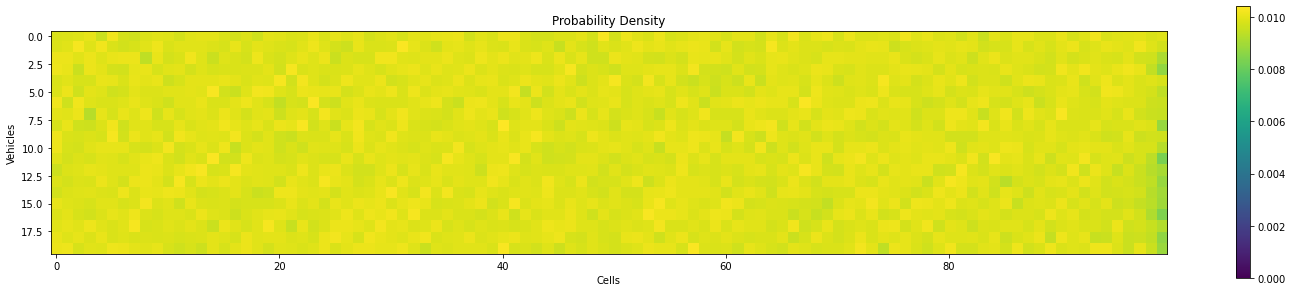

In [41]:
plt.figure(figsize=(25, 5))
plt.imshow(Density/nt, vmin=0)
plt.colorbar()
plt.xlabel('Cells')
plt.ylabel('Vehicles')
plt.title('Probability Density')
plt.show()
plt.close()

We are interested in the stationary probability distribution $\lim_{t \rightarrow \infty} P$. We expect the standard deviation accross the elements of the density to vanish for large $t$.

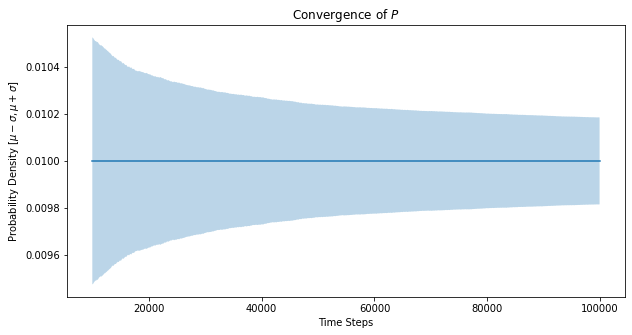

In [42]:
_t = np.array([v[0] for v in density_convergence])
_m = np.array([v[1] for v in density_convergence])
_s = np.array([v[2] for v in density_convergence])

plt.figure(figsize=(10,5))
plt.fill_between(_t, _m - _s, _m + _s, alpha=0.3)
plt.plot(_t, _m)
plt.xlabel('Time Steps')
plt.ylabel('Probability Density $[\mu-\sigma , \mu+\sigma]$')
plt.title('Convergence of $P$')
plt.show()
plt.close()

We also need to check how the stationary probability distribution $\lim_{t \rightarrow \infty} P$ compares along the corridor.

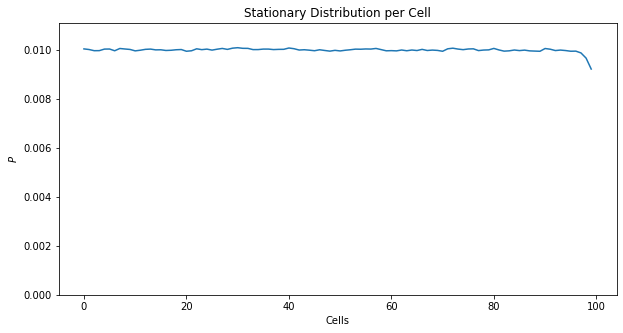

In [43]:
D_sum = Density.sum(axis=1)
Density_normalized = Density / D_sum[:, np.newaxis]
plt.figure(figsize=(10,5))
plt.plot(range(nc), Density_normalized.mean(axis=0))
plt.ylim(0, 1.1*Density_normalized.mean(axis=0).max())
plt.xlabel('Cells')
plt.ylabel('$P$')
plt.title('Stationary Distribution per Cell')
plt.show()
plt.close()

# Simulation with very slow vehicles
Let's change the probabilities for vehicles to remain in the same cell, i.e. they move slow.

In [70]:
# Number of cells
nc = 100
# Number of vehicles
nv = 20
# number of timesteps
nt = 100000
# P_stay interval
P_stay_min = 0.20  ## 0.05
P_stay_max = 0.90  ## 0.20

# Intialize
Corridor_slow, Position_slow, P_stay_slow, Density_slow = simulation_init(nc, nv, nt, P_stay_min, P_stay_max)

# Define Trajectory matrix
maxTrajectoryTimeSteps = 200
Trajectory_slow = np.zeros((min([nt, maxTrajectoryTimeSteps]), nc))

T_0 = now()

density_convergence_slow = []
for t in range(nt):
    simulation_step(t, Corridor_slow, Position_slow, P_stay_slow, Density_slow, Trajectory_slow)
    if (t >= 10000) and (t % 100 == 0):
        D_sum = Density_slow.sum(axis=1)
        Density_normalized_slow = Density_slow / D_sum[:, np.newaxis]
        density_convergence_slow.append( (t, Density_normalized_slow.reshape(-1).mean(), Density_normalized_slow.reshape(-1).std()) )

print(f"Elapsed time: {now()-T_0}")

Number of cells in air corridor: 100
Number of vehicles: 20
Elapsed time: 0:00:11.656756


Let's compare the two simulations approach the stationary distribution.

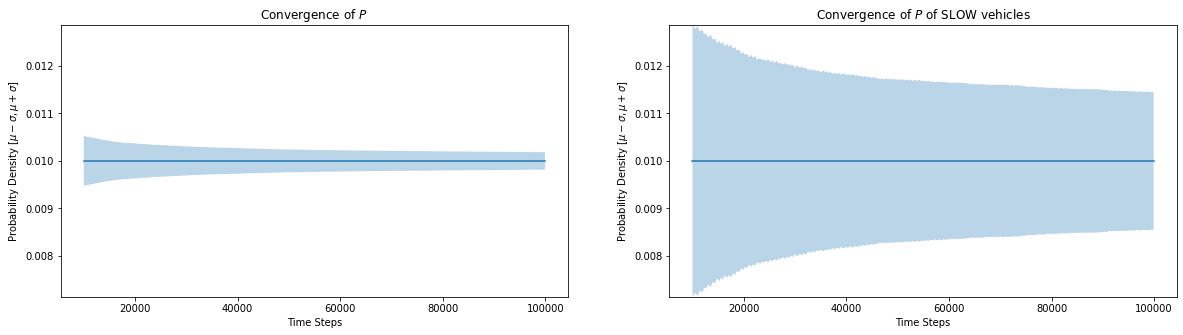

In [52]:
_t = np.array([v[0] for v in density_convergence])
_m = np.array([v[1] for v in density_convergence])
_s = np.array([v[2] for v in density_convergence])

_t_slow = np.array([v[0] for v in density_convergence_slow])
_m_slow = np.array([v[1] for v in density_convergence_slow])
_s_slow = np.array([v[2] for v in density_convergence_slow])

y_max = max([np.max(_m+_s), np.max(_m_slow+_s_slow)])
y_min = min([np.min(_m-_s), np.min(_m_slow-_s_slow)])

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.fill_between(_t, _m - _s, _m + _s, alpha=0.3)
plt.plot(_t, _m)
plt.ylim(y_min, y_max)
plt.xlabel('Time Steps')
plt.ylabel('Probability Density $[\mu-\sigma , \mu+\sigma]$')
plt.title('Convergence of $P$')

plt.subplot(1,2,2)
plt.fill_between(_t_slow, _m_slow - _s_slow, _m_slow + _s_slow, alpha=0.3)
plt.plot(_t_slow, _m_slow)
plt.ylim(y_min, y_max)
plt.xlabel('Time Steps')
plt.ylabel('Probability Density $[\mu-\sigma , \mu+\sigma]$')
plt.title('Convergence of $P$ of SLOW vehicles')

plt.show()
plt.close()

The simulation with *slow* vehicles takes much longer to converge. The standard deviation is much greater in the second simulation.

Now, let's compare along the corridor

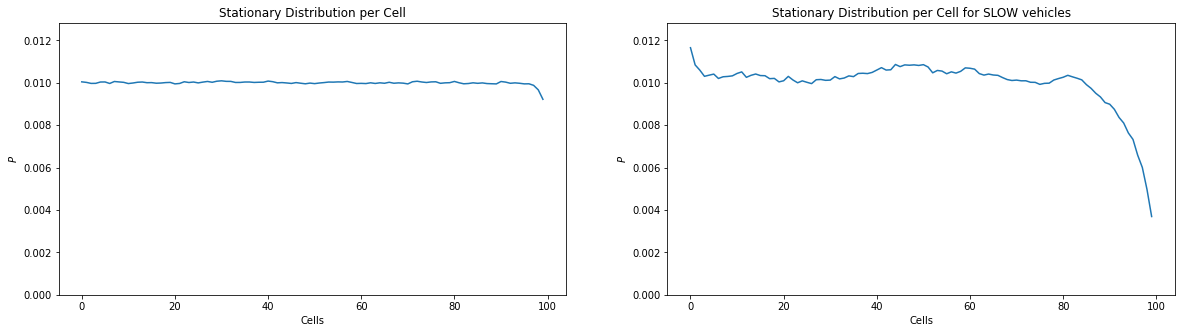

In [54]:
D_sum = Density.sum(axis=1)
Density_normalized = Density / D_sum[:, np.newaxis]

D_sum_slow = Density_slow.sum(axis=1)
Density_normalized_slow = Density_slow / D_sum_slow[:, np.newaxis]

y_max = max(Density_normalized.mean(axis=0).max(), Density_normalized_slow.mean(axis=0).max())

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range(nc), Density_normalized.mean(axis=0))
plt.ylim(0, 1.1*y_max)
plt.xlabel('Cells')
plt.ylabel('$P$')
plt.title('Stationary Distribution per Cell')

plt.subplot(1,2,2)
plt.plot(range(nc), Density_normalized_slow.mean(axis=0))
plt.ylim(0, 1.1*y_max)
plt.xlabel('Cells')
plt.ylabel('$P$')
plt.title('Stationary Distribution per Cell for SLOW vehicles')
plt.show()
plt.close()

In the case of *slow* vehicles the cells at the end of the corridor are less likely to be occupied. It may take many more simulation steps to even out the distrubution.

# Vehicle Trajectories
Show how the vehicles move along the corridor (horizontal axis). The vertical axis depicts the time.

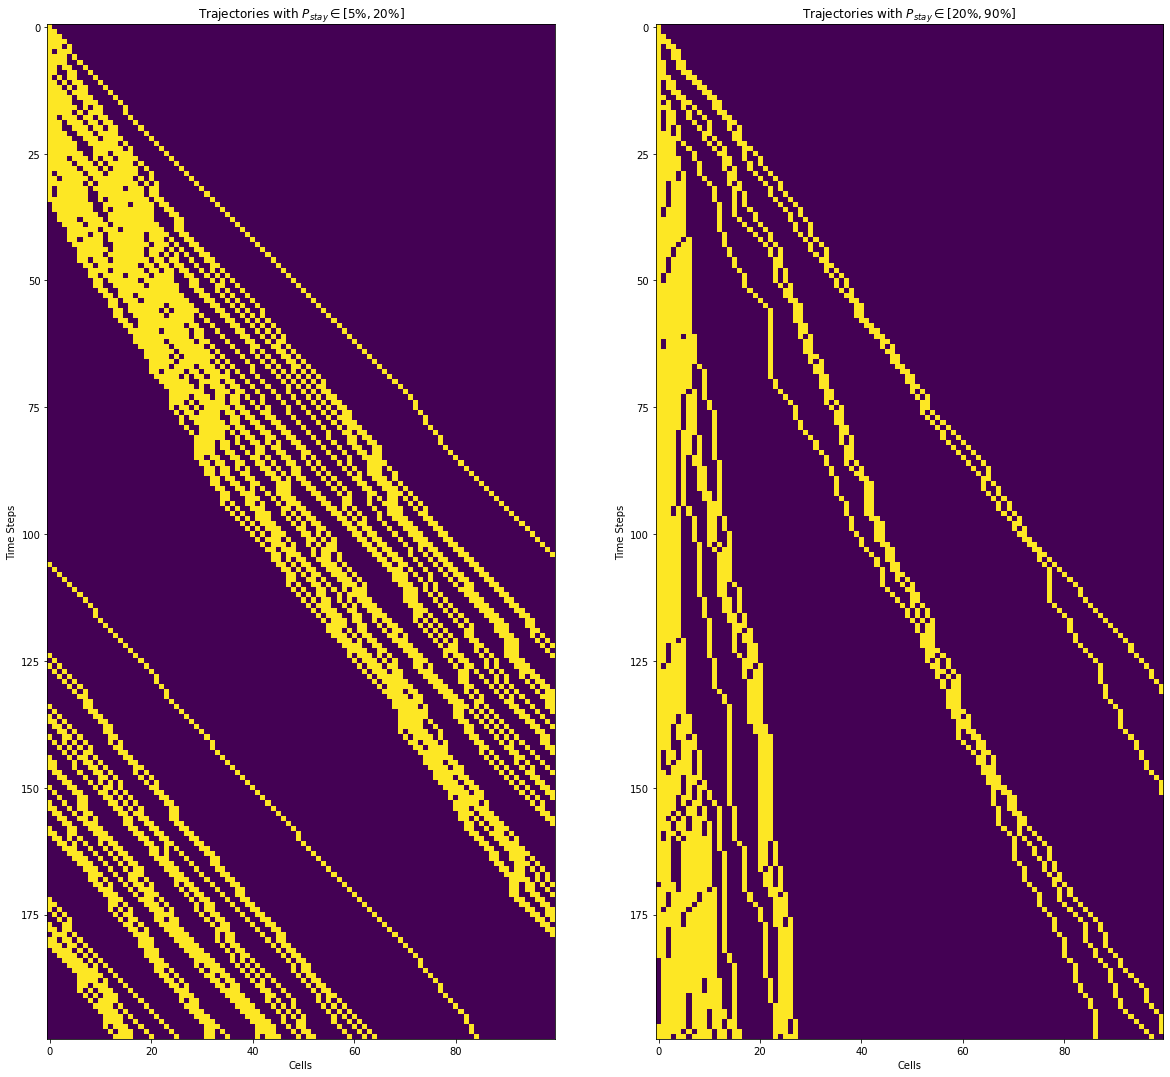

In [71]:
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.xlabel('Cells')
plt.ylabel('Time Steps')
plt.title('Trajectories with $P_{stay} \in [5\%, 20\%]$')
plt.imshow(Trajectory, vmin=0)
plt.subplot(1,2,2)
plt.imshow(Trajectory_slow, vmin=0)
plt.xlabel('Cells')
plt.ylabel('Time Steps')
plt.title('Trajectories with $P_{stay} \in [20\%, 90\%]$')

plt.show()
plt.close()


# Things to try

- Change the range of $P_{\rm stay}$, i.e., fast vs slow moving vehicles, mixture for fast and slow
- Change traffic volume, i.e. ratio of vehicles to cells in corridor $\frac{nv}{nc}$
- Increase number of time steps $nt$ for convergence